# Transaction Data Analysis

This notebook analyzes transaction patterns and creates a graph structure for money laundering detection.

In [238]:
!pip install polars
!pip install networkx
!pip install matplotlib
!pip install igraph

---

## Setup

Install required library.

In [239]:
import polars as pl
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig

# df = pl.read_csv('data/HI-Small_Trans.csv')
# Try lazy frame
df = pl.read_csv('data/HI-Small_Trans.csv')

# Sample only 10% of full data for memory management, commented out if want full data
df = df.sample(fraction=0.10, with_replacement=False, seed=42).lazy()

G = nx.DiGraph()
SG = nx.DiGraph()

---

## Load Data

Read transaction data from CSV file.

In [240]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
str,i64,str,i64,str,f64,str,f64,str,str,i64
"""2022/09/01 14:51""",122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
"""2022/09/02 12:05""",70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
"""2022/09/07 22:23""",14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
"""2022/09/02 15:44""",14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
"""2022/09/01 00:28""",12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
"""2022/09/06 20:48""",124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
"""2022/09/02 01:05""",70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
"""2022/09/09 12:46""",12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


In [241]:
df = df.with_columns(
    pl.col('Timestamp').str.strptime(pl.Datetime, format='%Y/%m/%d %H:%M')
)

---

## Data Preparation

Convert timestamp column to datetime format.

In [242]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-06 20:48:00,124,"""813B87B71""",124,"""813B87B71""",0.026602,"""Bitcoin""",0.026602,"""Bitcoin""","""Bitcoin""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


---

Disregard transaction with Payment Format "Reinvesment"

In [243]:
df = df.filter(pl.col("Payment Format") != "Reinvestment").filter(pl.col("Account") != pl.col("Account_duplicated_0"))

In [244]:
df.collect()

Timestamp,From Bank,Account,To Bank,Account_duplicated_0,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
datetime[μs],i64,str,i64,str,f64,str,f64,str,str,i64
2022-09-01 14:51:00,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
2022-09-02 12:05:00,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
2022-09-07 22:23:00,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
2022-09-02 15:44:00,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
2022-09-01 00:28:00,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0
…,…,…,…,…,…,…,…,…,…,…
2022-09-04 11:12:00,8354,"""8064E6650""",3242,"""808CA8BB0""",111.41,"""US Dollar""",111.41,"""US Dollar""","""Cash""",0
2022-09-02 01:05:00,70,"""1004286A8""",111141,"""8144DAE90""",1614.02,"""Euro""",1614.02,"""Euro""","""Cash""",0
2022-09-09 12:46:00,12381,"""8085123D0""",216645,"""80F2F2D50""",320.56,"""US Dollar""",320.56,"""US Dollar""","""Credit Card""",0


---

## Temporal View Graph Initialization

### Create Nodes

Build graph nodes from transactions with ID, sender, receiver, time, amount, and label.

In [245]:
nodes = df.with_row_index("node_id").select([
    pl.col("node_id"),
    pl.col("Account").alias("f_i"),                # From
    pl.col("Account_duplicated_0").alias("b_i"),   # Beneficiary
    pl.col("Timestamp").alias("t_i"),              # Time
    pl.col("Amount Received").alias("a_i"),        # Amount
    pl.col("Is Laundering")                        # Ground truth
])

In [246]:
nodes.collect().head()

node_id,f_i,b_i,t_i,a_i,Is Laundering
u32,str,str,datetime[μs],f64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0


---

Adding nodes df into nx graph

In [247]:
# for row in nodes.collect().to_dicts():
#     G.add_node(row["node_id"], 
#                f_i=row["f_i"], 
#                b_i=row["b_i"], 
#                t_i=row["t_i"], 
#                a_i=row["a_i"], 
#                is_laundering=row["Is Laundering"])

In [248]:
# Sample some nodes to inspect
# sample_nodes = list(G.nodes)[:5]
# for node in sample_nodes:
#     print(f"Node {node}: {G.nodes[node]}")

---

### Create Edges

Connect transactions where one receiver becomes the sender in another transaction.

In [249]:
edges = nodes.join(
    nodes,
    left_on="b_i", 
    right_on="f_i",
    suffix="_d",
    how="inner"
).rename({"node_id": "v_s", "node_id_d": "v_d"})

In [250]:
edges.collect()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64
96927,"""100428810""","""808376670""",2022-09-10 12:26:00,94.14,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
219894,"""8076829F0""","""808376670""",2022-09-02 18:32:00,1537.16,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
274253,"""100428810""","""808376670""",2022-09-04 08:28:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
293035,"""100428810""","""808376670""",2022-09-02 01:56:00,55.19,0,0,"""808763050""",2022-09-01 14:51:00,165.58,0
13047,"""80571C290""","""100428660""",2022-09-09 06:35:00,529.2,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0
…,…,…,…,…,…,…,…,…,…,…
440264,"""805836AE0""","""1004286A8""",2022-09-09 16:27:00,3503.46,0,448732,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
443201,"""803BA4C60""","""1004286A8""",2022-09-02 13:23:00,1370.04,0,448732,"""8144DAE90""",2022-09-02 01:05:00,1614.02,0
67950,"""801F49CC0""","""8085123D0""",2022-09-08 00:56:00,1543.08,0,448733,"""80F2F2D50""",2022-09-09 12:46:00,320.56,0


In [251]:
timedelta = pl.duration(hours=24)

---

### Filter Edges

Keep only edges where the second transaction occurs within 24 hours after the first.

In [252]:
edges = edges.filter(
    (pl.col("t_i_d") > pl.col("t_i")) & 
    (pl.col("t_i_d") < pl.col("t_i") + timedelta)
)

adding edges to graph G

In [253]:
# for row in edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect().to_dicts():
#     print(row)
#     break

---

### Temporal View Results

Display final nodes and edges.

In [254]:
print(nodes.collect())

shape: (448_736, 6)
┌─────────┬───────────┬───────────┬─────────────────────┬──────────┬───────────────┐
│ node_id ┆ f_i       ┆ b_i       ┆ t_i                 ┆ a_i      ┆ Is Laundering │
│ ---     ┆ ---       ┆ ---       ┆ ---                 ┆ ---      ┆ ---           │
│ u32     ┆ str       ┆ str       ┆ datetime[μs]        ┆ f64      ┆ i64           │
╞═════════╪═══════════╪═══════════╪═════════════════════╪══════════╪═══════════════╡
│ 0       ┆ 808376670 ┆ 808763050 ┆ 2022-09-01 14:51:00 ┆ 165.58   ┆ 0             │
│ 1       ┆ 100428660 ┆ 800C08F10 ┆ 2022-09-02 12:05:00 ┆ 1000.0   ┆ 0             │
│ 2       ┆ 8035A5A50 ┆ 8035CB140 ┆ 2022-09-07 22:23:00 ┆ 4449.0   ┆ 0             │
│ 3       ┆ 8028B20E0 ┆ 80B5A8EF0 ┆ 2022-09-02 15:44:00 ┆ 24022.22 ┆ 0             │
│ 4       ┆ 803109B90 ┆ 80A633740 ┆ 2022-09-01 00:28:00 ┆ 2777.01  ┆ 0             │
│ …       ┆ …         ┆ …         ┆ …                   ┆ …        ┆ …             │
│ 448731  ┆ 8064E6650 ┆ 808CA8BB0 ┆ 2022-09-0

In [255]:
print(edges.select(["v_s", "v_d", "t_i", "t_i_d"]).collect())

shape: (342_658, 4)
┌────────┬────────┬─────────────────────┬─────────────────────┐
│ v_s    ┆ v_d    ┆ t_i                 ┆ t_i_d               │
│ ---    ┆ ---    ┆ ---                 ┆ ---                 │
│ u32    ┆ u32    ┆ datetime[μs]        ┆ datetime[μs]        │
╞════════╪════════╪═════════════════════╪═════════════════════╡
│ 15338  ┆ 1      ┆ 2022-09-02 09:51:00 ┆ 2022-09-02 12:05:00 │
│ 17484  ┆ 1      ┆ 2022-09-02 10:00:00 ┆ 2022-09-02 12:05:00 │
│ 49381  ┆ 1      ┆ 2022-09-02 07:18:00 ┆ 2022-09-02 12:05:00 │
│ 76094  ┆ 1      ┆ 2022-09-02 07:35:00 ┆ 2022-09-02 12:05:00 │
│ 76372  ┆ 1      ┆ 2022-09-02 02:02:00 ┆ 2022-09-02 12:05:00 │
│ …      ┆ …      ┆ …                   ┆ …                   │
│ 440264 ┆ 448730 ┆ 2022-09-09 16:27:00 ┆ 2022-09-10 13:08:00 │
│ 212057 ┆ 448732 ┆ 2022-09-02 00:29:00 ┆ 2022-09-02 01:05:00 │
│ 253082 ┆ 448732 ┆ 2022-09-02 00:08:00 ┆ 2022-09-02 01:05:00 │
│ 340467 ┆ 448732 ┆ 2022-09-02 00:44:00 ┆ 2022-09-02 01:05:00 │
│ 414642 ┆ 448732 ┆ 

---

## Second Order Graph Creation

### Edge creation

create a second order graph edges from Temporal graph's edges

In [256]:
s_edges = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("v_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("v_d")
]).select(["v_s", "v_d"])

In [257]:
s_edges.collect().head()

v_s,v_d
str,str
"""81269FE50->100428660""","""100428660->800C08F10"""
"""8070EAE50->100428660""","""100428660->800C08F10"""
"""806018480->100428660""","""100428660->800C08F10"""
"""80D167C20->100428660""","""100428660->800C08F10"""
"""80C710A10->100428660""","""100428660->800C08F10"""


---

### Weight Calculation

In [258]:
# Count times where one node goes to another
s_edges_with_count = s_edges.group_by(["v_s", "v_d"]).agg([
    pl.len().alias("spec_count")
])

denom_P = s_edges.group_by("v_s").agg([
    pl.len().alias("s_to_any")
])

denom_P_prime = s_edges.group_by("v_d").agg([
    pl.len().alias("any_to_d")
])

In [259]:
print(s_edges_with_count.collect().head())

shape: (5, 3)
┌──────────────────────┬──────────────────────┬────────────┐
│ v_s                  ┆ v_d                  ┆ spec_count │
│ ---                  ┆ ---                  ┆ ---        │
│ str                  ┆ str                  ┆ u32        │
╞══════════════════════╪══════════════════════╪════════════╡
│ 80602C390->100428660 ┆ 100428660->80AA66210 ┆ 1          │
│ 8082338C0->100428660 ┆ 100428660->80B4D37F0 ┆ 1          │
│ 8040E7BC0->100428738 ┆ 100428738->803E65EE0 ┆ 1          │
│ 8131F0060->1004286A8 ┆ 1004286A8->80E7AAFE0 ┆ 1          │
│ 800AFF350->1004286A8 ┆ 1004286A8->81220B830 ┆ 1          │
└──────────────────────┴──────────────────────┴────────────┘


In [260]:
print(denom_P.collect().head())

print(denom_P_prime.collect().head())

shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_s                  ┆ s_to_any │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 1004287C8->8060D3390 ┆ 2        │
│ 806847A00->80AC30900 ┆ 1        │
│ 813714871->813B3F0D1 ┆ 1        │
│ 801E5E0B0->80207F1B0 ┆ 1        │
│ 800590530->8017C09F0 ┆ 1        │
└──────────────────────┴──────────┘
shape: (5, 2)
┌──────────────────────┬──────────┐
│ v_d                  ┆ any_to_d │
│ ---                  ┆ ---      │
│ str                  ┆ u32      │
╞══════════════════════╪══════════╡
│ 8078DE080->80AC1B4D0 ┆ 1        │
│ 100428A08->811BF8460 ┆ 2        │
│ 802A26660->80AF47680 ┆ 2        │
│ 8060FFFE0->806F867D0 ┆ 1        │
│ 808299240->80892CBF0 ┆ 2        │
└──────────────────────┴──────────┘


In [261]:
s_edges_with_weight = s_edges_with_count.join(
    denom_P,
    on="v_s",
    how="left"
).join(
    denom_P_prime,
    on="v_d",
    how="left"
).with_columns([
    (pl.col("spec_count") / pl.col("s_to_any")).alias("P"),
    (pl.col("spec_count") / pl.col("any_to_d")).alias("P_prime")
]).with_columns([
    (pl.max_horizontal([pl.col("P"), pl.col("P_prime")])).alias("weight")
])

In [262]:
print(s_edges_with_weight.collect().head())

shape: (5, 8)
┌───────────────┬──────────────┬────────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ v_s           ┆ v_d          ┆ spec_count ┆ s_to_any ┆ any_to_d ┆ P        ┆ P_prime  ┆ weight   │
│ ---           ┆ ---          ┆ ---        ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str           ┆ str          ┆ u32        ┆ u32      ┆ u32      ┆ f64      ┆ f64      ┆ f64      │
╞═══════════════╪══════════════╪════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 806701DD0->10 ┆ 100428660->8 ┆ 1          ┆ 1661     ┆ 32       ┆ 0.000602 ┆ 0.03125  ┆ 0.03125  │
│ 0428660       ┆ 00F35550     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 8026829E0->10 ┆ 100428660->8 ┆ 1          ┆ 1057     ┆ 60       ┆ 0.000946 ┆ 0.016667 ┆ 0.016667 │
│ 0428660       ┆ 11C7C640     ┆            ┆          ┆          ┆          ┆          ┆          │
│ 810FC1800->10 ┆ 1004286A8->8 ┆ 1          ┆ 1343     ┆ 34       ┆ 0.000745 

---

### Sanity Checking Second Order Graph

In [263]:
edges.collect().shape, s_edges_with_weight.collect().shape

((342658, 11), (299827, 8))

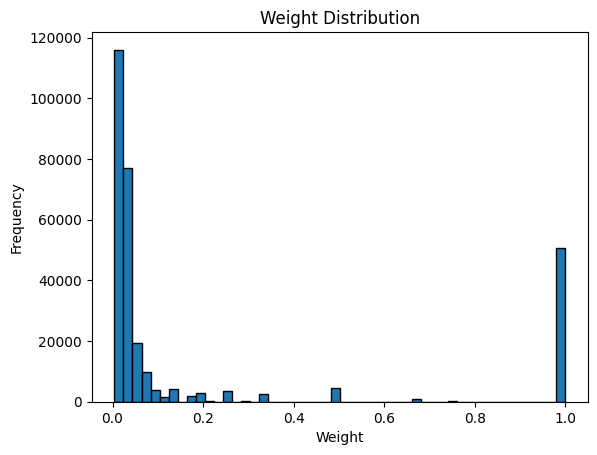

In [264]:
import matplotlib.pyplot as plt

weights = s_edges_with_weight.select("weight").collect().to_numpy().flatten()
plt.hist(weights, bins=50, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Distribution')
plt.show()

Text(0.5, 1.0, "P vs P' Distribution")

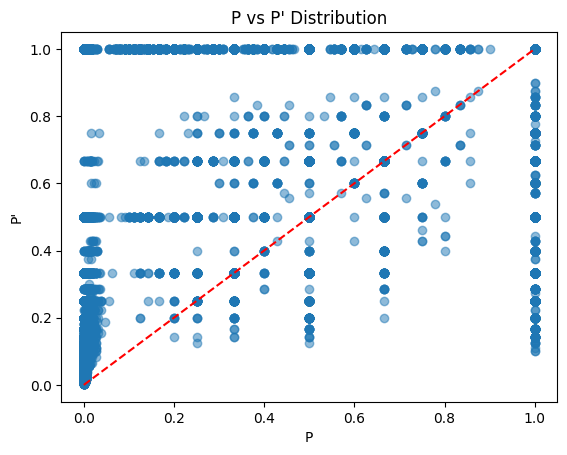

In [265]:
# P vs P_prime scatter plot (should see which dominates)
data = s_edges_with_weight.select(["P", "P_prime", "weight"]).collect()
plt.scatter(data["P"], data["P_prime"], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('P')
plt.ylabel("P'")
plt.title("P vs P' Distribution")

In [266]:
s_edges_with_weight.collect()

v_s,v_d,spec_count,s_to_any,any_to_d,P,P_prime,weight
str,str,u32,u32,u32,f64,f64,f64
"""8048D7570->1004286A8""","""1004286A8->808DF7CC0""",1,1476,33,0.000678,0.030303,0.030303
"""80DE22A60->1004286A8""","""1004286A8->801D7BED0""",1,1270,10,0.000787,0.1,0.1
"""804206B40->1004286A8""","""1004286A8->808088550""",1,1274,21,0.000785,0.047619,0.047619
"""801BB1D80->100428660""","""100428660->800871500""",2,2240,158,0.000893,0.012658,0.012658
"""811DE1100->100428660""","""100428660->80FE98F70""",1,2158,41,0.000463,0.02439,0.02439
…,…,…,…,…,…,…,…
"""80013D5C0->100428660""","""100428660->8066E79A0""",1,854,16,0.001171,0.0625,0.0625
"""800611420->800855730""","""800855730->802DDBDC0""",1,5,1,0.2,1.0,1.0
"""810FC1800->1004286A8""","""1004286A8->80BD04FF0""",1,1343,15,0.000745,0.066667,0.066667


---

### Apply second order graph's weight to Temporal graph's edges

In [267]:
edges_with_weight = edges.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i")], separator="->").alias("tx_s"),
    pl.concat_str([pl.col("b_i"), pl.col("b_i_d")], separator="->").alias("tx_d")
]).join(
    s_edges_with_weight.select([
        "v_s", "v_d", "weight"
    ]),
    left_on=["tx_s", "tx_d"],
    right_on=["v_s", "v_d"],
    how="left"
# )
).drop([
    "tx_s", "tx_d"
])

---

## Community Detection with Leiden

In [268]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 1)

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,f64
124772,"""100428660""","""800704A30""",2022-09-06 16:52:00,7093.06,1,6195,"""809031710""",2022-09-07 09:52:00,212.95,0,1.0
308926,"""80018E990""","""800059C00""",2022-09-08 13:14:00,6742.83,1,22607,"""80018E990""",2022-09-08 14:22:00,1518.21,0,1.0
5364,"""8001BB380""","""8001A6870""",2022-09-01 17:48:00,1499.02,1,24285,"""8016C6620""",2022-09-01 20:46:00,29.05,0,1.0
129376,"""804B56250""","""807C35490""",2022-09-06 14:55:00,4445.55,1,25791,"""808B09840""",2022-09-07 12:53:00,1223.72,0,1.0
410465,"""100428660""","""800EEA500""",2022-09-06 11:14:00,110.99,1,33328,"""81248A320""",2022-09-07 03:13:00,2259.8,0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
145,"""8021353D0""","""80266F880""",2022-09-09 09:47:00,14368.04,1,426209,"""80286DE40""",2022-09-10 02:27:00,9783.49,0,1.0
44803,"""8061A6010""","""806C62690""",2022-09-06 13:24:00,832531.23,1,431149,"""8073A2C80""",2022-09-07 04:14:00,3.6226e6,0,1.0
234843,"""80777E5C0""","""800E3D880""",2022-09-06 17:05:00,4264.34,1,432088,"""808173600""",2022-09-07 06:36:00,1135.38,0,1.0


In [269]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 1)["weight"].value_counts().sort("weight")

weight,count
f64,u32
0.333333,1
0.5,2
1.0,84


In [270]:
edges_with_weight.collect().filter(pl.col("Is Laundering") == 0)["weight"].value_counts().sort("weight")

weight,count
f64,u32
0.004202,20
0.004329,12
0.00463,18
0.005155,63
0.005319,25
…,…
0.8,220
0.833333,75
0.857143,54


In [271]:
df_for_leiden = edges_with_weight.select([
    pl.concat_str(["f_i", "b_i", "t_i"]).alias("source_node"),
    pl.concat_str(["b_i", "b_i_d", "t_i_d"]).alias("target_node"),
    pl.col("weight")
])

In [272]:
df_for_leiden.collect()

source_node,target_node,weight
str,str,f64
"""81269FE501004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""8070EAE501004286602022-09-02 1…","""100428660800C08F102022-09-02 1…",0.041667
"""8060184801004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""80D167C201004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
"""80C710A101004286602022-09-02 0…","""100428660800C08F102022-09-02 1…",0.041667
…,…,…
"""805836AE01004286A82022-09-09 1…","""1004286A880DEC81F02022-09-10 1…",0.066667
"""8093BB6401004286A82022-09-02 0…","""1004286A88144DAE902022-09-02 0…",0.25
"""80E2EFCF01004286A82022-09-02 0…","""1004286A88144DAE902022-09-02 0…",0.25


In [273]:
df_for_leiden_with_weight_filtered = df_for_leiden.filter(pl.col("weight") >= 0.5)

In [274]:
df_for_leiden_with_weight_filtered.collect()

source_node,target_node,weight
str,str,f64
"""8001A84608001E5B002022-09-08 0…","""8001E5B00800A36BC02022-09-08 1…",1.0
"""80979071080F2938C02022-09-08 1…","""80F2938C08104648502022-09-09 0…",1.0
"""800284530800798B002022-09-06 1…","""800798B008009E68A02022-09-07 1…",1.0
"""8005DBC308017C91C02022-09-07 1…","""8017C91C0802E2DAE02022-09-08 1…",1.0
"""8090F74E08091977702022-09-01 1…","""80919777080924BA002022-09-02 0…",1.0
…,…,…
"""100428660807276BC02022-09-08 2…","""807276BC0808D7CE602022-09-09 0…",1.0
"""80E1A3C5080E23FCD02022-09-01 1…","""80E23FCD080E7EB7E02022-09-02 1…",1.0
"""80E868AD080F1238A02022-09-01 2…","""80F1238A080F479BB02022-09-02 0…",1.0


In [275]:
edges_data = df_for_leiden_with_weight_filtered.select([
    "source_node", "target_node", "weight"
]).collect().to_numpy()

In [276]:
g = ig.Graph.TupleList(edges_data, directed=True, weights=True)

In [277]:
partition = g.community_leiden(weights='weight', objective_function='modularity')

In [278]:
partition

In [279]:
# Create a mapping of Transaction ID -> Community ID
node_names = g.vs["name"]
community_ids = partition.membership

community_df = pl.LazyFrame({
    "node_id_str": node_names,
    "community_id": community_ids
})

# Now you can join this back to your original transaction data to see the "Fraud Rings"

In [280]:
community_df.collect().head()

node_id_str,community_id
str,i64
"""8001A84608001E5B002022-09-08 0…",0
"""8001E5B00800A36BC02022-09-08 1…",0
"""80979071080F2938C02022-09-08 1…",1
"""80F2938C08104648502022-09-09 0…",1
"""800284530800798B002022-09-06 1…",2


---

## Anomalous Communities Detection

### Applying Community ID back to Temporal Node

In [281]:
nodes_with_community = nodes.with_columns([
    pl.concat_str([pl.col("f_i"), pl.col("b_i"), pl.col("t_i")]).alias("node_id_str")
]).join(
    community_df,
    on="node_id_str",
    how="left"
).drop("node_id_str")

In [282]:
nodes_with_community.collect()

node_id,f_i,b_i,t_i,a_i,Is Laundering,community_id
u32,str,str,datetime[μs],f64,i64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0,null
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0,28550
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0,null
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0,null
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0,null
…,…,…,…,…,…,…
448731,"""8064E6650""","""808CA8BB0""",2022-09-04 11:12:00,111.41,0,null
448732,"""1004286A8""","""8144DAE90""",2022-09-02 01:05:00,1614.02,0,null
448733,"""8085123D0""","""80F2F2D50""",2022-09-09 12:46:00,320.56,0,null


In [283]:
#count nodes that has community_id not null
nodes_with_community.collect().filter(pl.col("community_id").is_not_null()).shape, nodes_with_community.collect().filter(pl.col("community_id").is_null()).shape

((110664, 7), (338072, 7))

In [284]:
# group by account in f_i and b_i to see how many unique community ids each account is involved in
f_i_communities = nodes_with_community.select([
    pl.col("f_i").alias("account"),
    pl.col("community_id")
]).filter(pl.col("community_id").is_not_null()
).unique().group_by("account").agg([
    pl.col("community_id").n_unique().alias("unique_communities")
])

b_i_communities = nodes_with_community.select([
    pl.col("b_i").alias("account"),
    pl.col("community_id")
]).filter(pl.col("community_id").is_not_null()).unique().group_by("account").agg([
    pl.col("community_id").n_unique().alias("unique_communities")
])

In [285]:
# merge f_i and b_i community counts
account_communities = pl.concat([f_i_communities, b_i_communities]).group_by("account").agg([
    pl.col("unique_communities").sum().alias("total_unique_communities")
])

In [286]:
account_communities.collect().shape

(86580, 2)

In [287]:
# count accounts in original df
unique_acc_left = df.select(pl.col("Account")).unique().collect().shape
unique_acc_right = df.select(pl.col("Account_duplicated_0")).unique().collect().shape

all_accounts = pl.concat([
    df.select(pl.col("Account").alias("account")),
    df.select(pl.col("Account_duplicated_0").alias("account"))
]).unique().collect()

In [288]:
all_accounts.shape

(242652, 1)

---

### Community features extraction

In [289]:
edges_with_weight.collect().head()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,f64
15338,"""81269FE50""","""100428660""",2022-09-02 09:51:00,363.25,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
17484,"""8070EAE50""","""100428660""",2022-09-02 10:00:00,119.65,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
49381,"""806018480""","""100428660""",2022-09-02 07:18:00,214.0,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
76094,"""80D167C20""","""100428660""",2022-09-02 07:35:00,1394.66,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667
76372,"""80C710A10""","""100428660""",2022-09-02 02:02:00,453.76,0,1,"""800C08F10""",2022-09-02 12:05:00,1000.0,0,0.041667


In [290]:
edges_with_weight.select(pl.len()).collect().item()


342658

In [291]:
edges_out_degrees = edges_with_weight.with_columns([
    pl.col("v_s").alias("node_id")
]).group_by("node_id").agg([
    pl.len().alias("tx_out_degree")
])

edges_in_degrees = edges_with_weight.with_columns([
    pl.col("v_d").alias("node_id")
]).group_by("node_id").agg([
    pl.len().alias("tx_in_degree")
])

In [292]:
edges_in_degrees.collect().head()

node_id,tx_in_degree
u32,u32
448710,1
392868,1
287853,24
324962,1
30300,2


In [293]:
edges_features = edges_with_weight.join(
    nodes_with_community.select([
        pl.col("node_id").alias("v_s"),
        pl.col("community_id").alias("community_id_s")
    ]),
    how="left",
    on="v_s"
).join(
    nodes_with_community.select([
        pl.col("node_id").alias("v_d"),
        pl.col("community_id").alias("community_id_d")
    ]),
    how="left",
    on="v_d"
).filter(
    pl.col("community_id_s") == pl.col("community_id_d")
).drop([
    "community_id_d"
])

In [294]:
edges_with_weight.collect().shape, edges_features.collect().shape

((342658, 12), (75269, 13))

In [295]:
edges_features = edges_features.join(
    edges_in_degrees,
    left_on="v_d",
    right_on="node_id",
    how="left"
# )
).join(
    edges_out_degrees,
    left_on="v_s",
    right_on="node_id",
    how="left"
)

In [296]:
edges_features.collect().head()

v_s,f_i,b_i,t_i,a_i,Is Laundering,v_d,b_i_d,t_i_d,a_i_d,Is Laundering_d,weight,community_id_s,tx_in_degree,tx_out_degree
u32,str,str,datetime[μs],f64,i64,u32,str,datetime[μs],f64,i64,f64,i64,u32,u32
371063,"""8001A8460""","""8001E5B00""",2022-09-08 07:32:00,1202.35,0,44,"""800A36BC0""",2022-09-08 18:37:00,93.81,0,1.0,0,1,3
45572,"""809790710""","""80F2938C0""",2022-09-08 10:00:00,1763.79,0,52,"""810464850""",2022-09-09 02:16:00,2004.7,0,1.0,1,1,1
149517,"""800284530""","""800798B00""",2022-09-06 17:02:00,21488.14,0,55,"""8009E68A0""",2022-09-07 10:45:00,1544.66,0,1.0,2,1,3
395304,"""8005DBC30""","""8017C91C0""",2022-09-07 19:40:00,3008.47,0,59,"""802E2DAE0""",2022-09-08 14:45:00,19.32,0,1.0,3,1,1
131807,"""8090F74E0""","""809197770""",2022-09-01 13:37:00,15032.99,0,61,"""80924BA00""",2022-09-02 07:04:00,5096.54,0,1.0,4,1,2


In [297]:
edges_features = edges_features.group_by("community_id_s").agg([
    pl.len().alias("num_edges"),
    pl.col("weight").mean().alias("avg_edge_weight"),
    pl.col("tx_in_degree").sum().alias("total_tx_in_degree"),
    pl.col("tx_out_degree").sum().alias("total_tx_out_degree"),
]).rename({
    "community_id_s": "community_id"
})

In [298]:
edges_features.collect().head()

community_id,num_edges,avg_edge_weight,total_tx_in_degree,total_tx_out_degree
i64,u32,f64,u32,u32
11278,1,1.0,1,1
13901,1,1.0,1,1
35802,2,1.0,2,4
16006,1,1.0,1,1
16521,1,1.0,1,1


In [299]:
nodes_with_community.collect().head()

node_id,f_i,b_i,t_i,a_i,Is Laundering,community_id
u32,str,str,datetime[μs],f64,i64,i64
0,"""808376670""","""808763050""",2022-09-01 14:51:00,165.58,0,null
1,"""100428660""","""800C08F10""",2022-09-02 12:05:00,1000.0,0,28550
2,"""8035A5A50""","""8035CB140""",2022-09-07 22:23:00,4449.0,0,null
3,"""8028B20E0""","""80B5A8EF0""",2022-09-02 15:44:00,24022.22,0,null
4,"""803109B90""","""80A633740""",2022-09-01 00:28:00,2777.01,0,null


In [320]:
# aggregate community features including number of transactions in each community, number of edges, total / average amount, average edge weight, in/out degree
community_features = nodes_with_community.group_by("community_id").agg([
    pl.len().alias("transactions_count"),
    pl.sum("a_i").alias("total_amount"),
    pl.mean("a_i").alias("average_amount"),
    pl.min("t_i").alias("first_transaction_time"),
    pl.max("t_i").alias("last_transaction_time"),
]).join(
    edges_features,
    left_on="community_id",
    right_on="community_id",
    how="left"
)
    

In [321]:
community_features.collect().shape

(39003, 10)

---

### Calculate hold time per account to compute for communities

In [334]:
events = pl.concat(
    [
        nodes_with_community.select(
            pl.col("b_i").alias("account"),
            pl.col("t_i"),
            pl.col("community_id").alias("community"),
            pl.col("Is Laundering"),
            pl.lit("in").alias("dir"),
        ),
        nodes_with_community.select(
            pl.col("f_i").alias("account"),
            pl.col("t_i"),
            pl.col("community_id").alias("community"),
            pl.col("Is Laundering"),
            pl.lit("out").alias("dir"),
        ),
    ],
    how="vertical",
)

hold_times = (
    events
    .sort(["account", "t_i"])
    .with_columns([
        pl.col("t_i").shift(-1).over("account").alias("next_t"),
        pl.col("dir").shift(-1).over("account").alias("next_dir"),
    ])
    # We should consider about the edge case that the account is still holding onto the money so we should fill next_t with time.now() or smth
    .filter(
        (pl.col("dir") == "in") &
        (pl.col("next_dir") == "out")
    )
    .with_columns(
        (pl.col("next_t") - pl.col("t_i")).alias("hold_time")
    )
)

account_features = (
    hold_times
    # .filter(pl.col("community").is_not_null())
    .group_by("account")
    .agg([
        pl.col("hold_time").mean().alias("avg_hold_time"),
        pl.len().alias("num_hold_events"),
        pl.col("Is Laundering").max().alias("Is Laundering"),
        pl.col("community").implode().alias("communities")
    ])
)

In [335]:
community_hold_times = account_features.explode("communities").rename({
    "communities": "community"
}).group_by("community").agg([
    pl.col("avg_hold_time").mean().alias("community_avg_hold_time"),
])

In [339]:
community_hold_times.collect().head()

community,community_avg_hold_time
i64,duration[μs]
9450,10h 54m 30s
30958,2d 5h 50m
12862,9h 7m
10376,1d 5h 23m 40s
20204,20h 36m


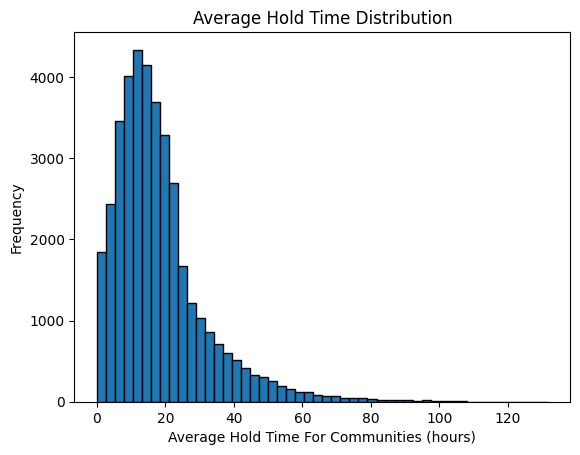

In [342]:
# plot histogram of avg_hold_time
# convert duration to numeric (hours) to avoid dtype issues in plt.hist
avg_hold_time_hours = (
	community_hold_times
	.select((pl.col("community_avg_hold_time").dt.total_seconds() / 3600).alias("community_avg_hold_time_hours"))
	.collect()
	.to_numpy()
	.flatten()
)

plt.hist(avg_hold_time_hours, bins=50, edgecolor='black')
plt.xlabel('Average Hold Time For Communities (hours)')
plt.ylabel('Frequency')
plt.title('Average Hold Time Distribution')
plt.show()

---

### Checking Fraud Accounts Hold Time Distribution

In [338]:
account_features.filter(pl.col("Is Laundering") == 1).collect()

account,avg_hold_time,num_hold_events,Is Laundering,communities
str,duration[μs],u32,i64,list[i64]
"""800051110""",1d 1h 7m,1,1,[null]
"""800059C00""",6m,1,1,[3032]
"""800061E50""",18h 48m,1,1,[35249]
"""800093C80""",1h 1m,1,1,[10994]
"""8000B8AB0""",4d 15h 38m,1,1,[4921]
…,…,…,…,…
"""812A09D40""",17h 32m,1,1,[38561]
"""812D0C600""",2d 4h 21m,1,1,[null]
"""812D22980""",18h 13m,1,1,[17672]


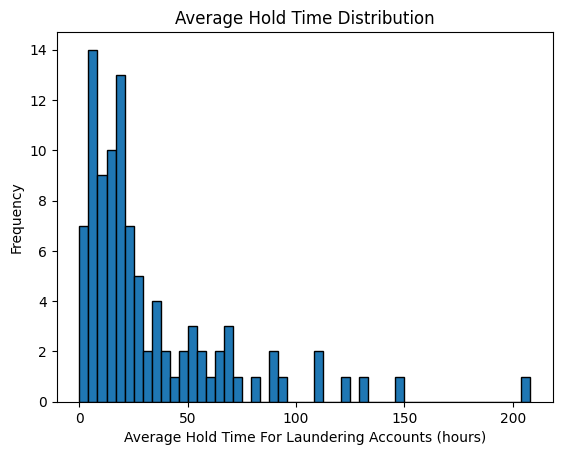

In [343]:
avg_hold_time_hours = (
	account_features.filter(pl.col("Is Laundering") == 1)
	.select((pl.col("avg_hold_time").dt.total_seconds() / 3600).alias("avg_hold_time_hours"))
	.collect()
	.to_numpy()
	.flatten()
)

plt.hist(avg_hold_time_hours, bins=50, edgecolor='black')
plt.xlabel('Average Hold Time For Laundering Accounts (hours)')
plt.ylabel('Frequency')
plt.title('Average Hold Time Distribution')
plt.show()

---

### Finalize community features

In [344]:
community_features = community_features.with_columns([
    (pl.col("num_edges") / pl.col("transactions_count")).alias("edge_density"),
]).join(
    community_hold_times,
    left_on="community_id",
    right_on="community"
)

In [345]:
community_features.collect().head()

community_id,transactions_count,total_amount,average_amount,first_transaction_time,last_transaction_time,num_edges,avg_edge_weight,total_tx_in_degree,total_tx_out_degree,edge_density,community_avg_hold_time
i64,u32,f64,f64,datetime[μs],datetime[μs],u32,f64,u32,u32,f64,duration[μs]
4603,2,971.27,485.635,2022-09-05 00:02:00,2022-09-05 03:30:00,1,1.0,1,1,0.5,3h 28m
30693,3,8279.54,2759.846667,2022-09-02 07:23:00,2022-09-02 18:28:00,2,1.0,2,2,0.666667,9h 19m 10s
37490,3,113038.69,37679.563333,2022-09-06 07:31:00,2022-09-06 08:45:00,2,1.0,4,2,0.666667,11h 52m 45s
4210,3,1.8356e7,6.1186e6,2022-09-01 10:17:00,2022-09-02 11:12:00,2,1.0,2,2,0.666667,12h 27m 30s
19284,3,31082.27,10360.756667,2022-09-07 06:44:00,2022-09-07 23:49:00,2,1.0,2,4,0.666667,11h 54m 40s


---

## Classifying Communities

### Rule based approach

- If community_avg_hold_time < 10th Percentile score +1

In [347]:
community_hold_time_10th_percentile = community_hold_times.select(
    pl.col("community_avg_hold_time").quantile(0.1)
).collect().item()

community_features = community_features.with_columns([
    (pl.col("community_avg_hold_time") < community_hold_time_10th_percentile).cast(pl.Int8).alias("low_hold_time_flag")
])

- 

In [348]:
community_features.collect().head()

community_id,transactions_count,total_amount,average_amount,first_transaction_time,last_transaction_time,num_edges,avg_edge_weight,total_tx_in_degree,total_tx_out_degree,edge_density,community_avg_hold_time,low_hold_time_flag
i64,u32,f64,f64,datetime[μs],datetime[μs],u32,f64,u32,u32,f64,duration[μs],i8
3415,3,5356.73,1785.576667,2022-09-04 03:21:00,2022-09-04 15:35:00,2,1.0,2,4,0.666667,1d 44m 30s,0
12192,2,61638.67,30819.335,2022-09-05 03:06:00,2022-09-05 20:51:00,1,1.0,1,1,0.5,17h 45m,0
5380,4,4053.39,1013.3475,2022-09-05 06:00:00,2022-09-06 08:11:00,3,1.0,5,3,0.75,12h 55m,0
9057,3,4665.18,1555.06,2022-09-07 06:00:00,2022-09-07 15:39:00,2,1.0,4,2,0.666667,3h 32m,1
32658,2,24242.94,12121.47,2022-09-05 14:35:00,2022-09-06 11:39:00,1,1.0,1,1,0.5,9h 46m 48s,0


## Account Level Risk scoring

---